<a href="https://colab.research.google.com/github/zakariaelaoufi/arcface-pytorch/blob/main/arcface_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install opendatasets --quiet

!pip install opendatasets --quiet

import opendatasets as od
import os

od.download('https://www.kaggle.com/datasets/hearfool/vggface2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: frf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hearfool/vggface2


100%|██████████| 2.32G/2.32G [00:15<00:00, 160MB/s] 


In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_data = '/content/vggface2'

In [ ]:
def generate_vggface_df(dir):
  image_path = []
  image_label = []
  for folder in os.listdir(dir):
      for label in os.listdir(dir + "/" + folder):
          for image in os.listdir(dir + "/" + folder + "/" + label):
              curr_path = dir + "/" + folder + "/" + label + "/" + image
              image_path.append(curr_path)
              image_label.append(label)

  return pd.DataFrame(zip(image_path, image_label), columns = ['image_path', 'label'])

In [ ]:
train_df = generate_vggface_df(path_data)
# val_df = generate_vggface_df(path_val)

In [ ]:
len(train_df)

197693

In [ ]:
class_idx = {}
for i, label in enumerate(sorted(train_df['label'].unique())):
    class_idx[label] = i

In [ ]:
train_df['label_'] = train_df['label'].map(class_idx)

In [ ]:
train_df.to_csv("vggfave_train.csv")
# val_df.to_csv("vggfave_val.csv")

In [ ]:
train_df.sample(5)

,image_path,label,label_
126457,/content/vggface2/train/n000172/0165_03.jpg,n000172,169
100591,/content/vggface2/train/n000388/0035_01.jpg,n000388,384
101495,/content/vggface2/train/n000281/0044_01.jpg,n000281,277
136527,/content/vggface2/train/n000041/0009_01.jpg,n000041,40
111086,/content/vggface2/train/n000217/0123_01.jpg,n000217,213


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.12, stratify=train_df['label_'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.4, stratify=val_df['label_'], random_state=42)

In [ ]:
val_df.sample(5)

,image_path,label,label_
61977,/content/vggface2/train/n000355/0142_03.jpg,n000355,351
5962,/content/vggface2/train/n000300/0031_01.jpg,n000300,296
194706,/content/vggface2/val/n001291/0134_01.jpg,n001291,537
8771,/content/vggface2/train/n000185/0205_01.jpg,n000185,182
99227,/content/vggface2/train/n000108/0093_01.jpg,n000108,107


In [ ]:
test_df.sample(5)

,image_path,label,label_
58550,/content/vggface2/train/n000496/0259_01.jpg,n000496,491
183003,/content/vggface2/val/n000394/0041_01.jpg,n000394,390
9846,/content/vggface2/train/n000102/0321_01.jpg,n000102,101
166378,/content/vggface2/train/n000424/0054_01.jpg,n000424,419
72463,/content/vggface2/train/n000236/0460_01.jpg,n000236,232


In [ ]:
len(train_df), len(val_df), len(test_df)

(173969, 14234, 9490)

<Axes: ylabel='Frequency'>

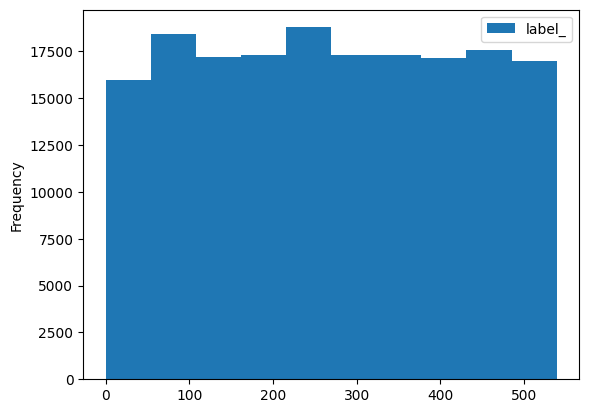

In [ ]:
train_df.plot(kind='hist')

In [ ]:
path_sample = val_df.sample(1).iloc[0]
print(path_sample)

image_path    /content/vggface2/train/n000081/0074_02.jpg
label                                             n000081
label_                                                 80
Name: 45162, dtype: object


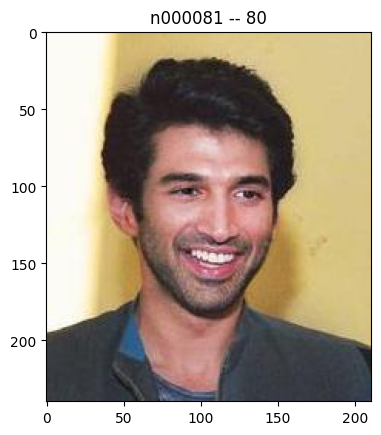

In [ ]:
image = cv2.imread(path_sample['image_path'])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title(f"{path_sample['label']} -- {path_sample['label_']}")
plt.imshow(image_rgb)
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import datetime as dt
from sklearn.metrics import accuracy_score
import kagglehub

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def resize_image(image, dsize=(224, 224)):
    resized_image = cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
class customDatasets(Dataset):
  def __init__(self, dataframe, transform=None):
     super().__init__()
     self.dataframe = dataframe
     self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index, 0]
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found or unreadable at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_resized = resize_image(image)

    label = torch.tensor(int(self.dataframe.iloc[index, 2]), dtype=torch.long)

    if self.transform:
        image_resized = self.transform(image_resized)

    return image_resized, label


In [ ]:
train_dataset = customDatasets(train_df, transform=transformer)
test_dataset = customDatasets(test_df, transform=transformer)
val_dataset = customDatasets(val_df, transform=transformer)

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

(224, 224, 3)


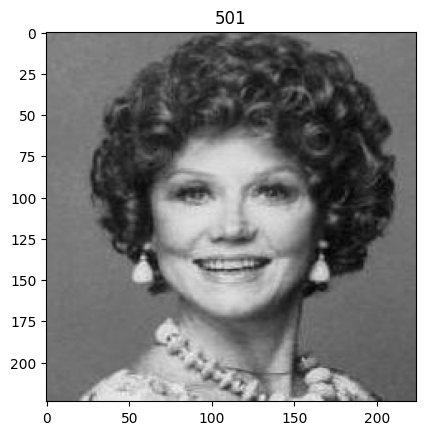

In [ ]:
images, labels = next(iter(train_dataloader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

for i in range(len(images)):
    image = images[i].transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)

    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.show()
    break

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.pointwise(self.depthwise(x))))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv(channels, channels)
        self.conv2 = DepthwiseSeparableConv(channels, channels)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))

class EfficientFRBackbone(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Downsample
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.stage1 = nn.Sequential(
            DepthwiseSeparableConv(32, 64),
            ResidualBlock(64),
            nn.MaxPool2d(2)
        )

        self.stage2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128),
            ResidualBlock(128),
            nn.MaxPool2d(2)
        )

        self.stage3 = nn.Sequential(
            DepthwiseSeparableConv(128, 256),
            ResidualBlock(256),
            nn.MaxPool2d(2)
        )

        self.stage4 = nn.Sequential(
            DepthwiseSeparableConv(256, 512),
            ResidualBlock(512),
            nn.AdaptiveAvgPool2d((1, 1))  # Global pooling
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.embedding(x)
        return x

In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, num_classes, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        W = F.normalize(self.weight)

        # Cosine similarity
        cos_theta = torch.matmul(embeddings, W.t()).clamp(-1, 1)

        # Apply angular margin
        theta = torch.acos(cos_theta)
        cos_theta_m = torch.cos(theta + self.m)

        # One-hot encoding
        one_hot = F.one_hot(labels, num_classes=num_classes).float()

        # Apply margin to correct class
        logits = self.s * (one_hot * cos_theta_m + (1 - one_hot) * cos_theta)
        return logits

In [ ]:
class FaceNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=512):
        super().__init__()
        self.backbone = EfficientFRBackbone(embedding_dim)
        self.arcface = ArcFace(embedding_dim, num_classes)

    def forward(self, x, labels=None):
        embeddings = self.backbone(x)
        if labels is not None:
            return self.arcface(embeddings, labels)
        return embeddings

In [ ]:
num_classes = len(train_df['label'].unique())
num_class2 = len(val_df['label'].unique())
num_class3 = len(test_df['label'].unique())
print(num_classes, num_class2, num_class3)

540 540 540


In [ ]:
train_files = set(train_df['image_path'])
val_files = set(val_df['image_path'])
print(f"Overlapping files: {len(train_files & val_files)}")

Overlapping files: 0


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
# print(f"Model initialized on {device}")

In [ ]:
model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
state_dict = torch.load("/content/arcface_model_final_23.pth")
model.load_state_dict(state_dict)
print(f"Model initialized on {device}")

Model initialized on cuda


In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
            Conv2d-5         [-1, 64, 112, 112]           2,048
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-8         [-1, 64, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]             576
           Conv2d-10         [-1, 64, 112, 112]           4,096
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-13         [-1, 64, 112, 112]               0
           Conv2d-14         [

In [ ]:
EPOCHS = 23
learning_rate = 1e-3
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
print("Starting training...")
history = {
    'train_loss': [], 'dev_loss': [],
    'train_acc': [], 'dev_acc': [],
    'lr': []
}

start_time = dt.datetime.now()

for epoch in range(EPOCHS):
    # === Training phase ===
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    # === Validation phase ===
    model.eval()
    epoch_dev_loss = 0
    dev_correct = 0
    dev_total = 0

    with torch.no_grad():
        dev_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in dev_loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            epoch_dev_loss += loss.item()

            preds = torch.argmax(outputs, 1)
            dev_correct += (preds == labels).sum().item()
            dev_total += labels.size(0)

            dev_loop.set_postfix(val_loss=loss.item())

    # === Calculate metrics ===
    train_loss = epoch_train_loss / len(train_dataloader)
    dev_loss = epoch_dev_loss / len(val_dataloader)
    train_acc = train_correct / train_total
    dev_acc = dev_correct / dev_total
    current_lr = optimizer.param_groups[0]['lr']

    # === Update history ===
    history['train_loss'].append(train_loss)
    history['dev_loss'].append(dev_loss)
    history['train_acc'].append(train_acc)
    history['dev_acc'].append(dev_acc)
    history['lr'].append(current_lr)

    # Update scheduler
    scheduler.step(dev_acc)

    # === Print epoch summary ===
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {dev_loss:.4f} | Acc: {dev_acc:.4f}")
    print(f"Current Learning Rate: {current_lr:.6f}")
    print("-" * 60)

    # === Save checkpoint every 10 epochs ===
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'arcface_model_artifact_{epoch}')

# Training completion
end_time = dt.datetime.now()
print(f"Training completed in: {end_time - start_time}")
torch.save(model.state_dict(), f'arcface_model_final_{EPOCHS}.pth')

Starting training...


Epoch 1/23 [Val]: 100%|██████████| 112/112 [02:31<00:00,  1.35s/it, val_loss=16.8]



Epoch 1/23 Summary:
Train Loss: 10.1248 | Acc: 0.0710
Val   Loss: 15.4776 | Acc: 0.0007
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 2/23 [Val]: 100%|██████████| 112/112 [01:33<00:00,  1.19it/s, val_loss=14.6]



Epoch 2/23 Summary:
Train Loss: 8.3970 | Acc: 0.1423
Val   Loss: 14.0558 | Acc: 0.0039
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 3/23 [Val]: 100%|██████████| 112/112 [01:27<00:00,  1.28it/s, val_loss=12.2]



Epoch 3/23 Summary:
Train Loss: 7.3004 | Acc: 0.2016
Val   Loss: 12.5543 | Acc: 0.0180
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 4/23 [Val]: 100%|██████████| 112/112 [01:23<00:00,  1.34it/s, val_loss=10.6]



Epoch 4/23 Summary:
Train Loss: 6.4711 | Acc: 0.2546
Val   Loss: 11.1045 | Acc: 0.0429
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 5/23 [Val]: 100%|██████████| 112/112 [01:31<00:00,  1.22it/s, val_loss=9.36]



Epoch 5/23 Summary:
Train Loss: 5.8052 | Acc: 0.3014
Val   Loss: 10.5028 | Acc: 0.0561
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 6/23 [Val]: 100%|██████████| 112/112 [01:24<00:00,  1.32it/s, val_loss=8.98]



Epoch 6/23 Summary:
Train Loss: 5.2618 | Acc: 0.3448
Val   Loss: 9.1007 | Acc: 0.1111
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 7/23 [Val]: 100%|██████████| 112/112 [03:20<00:00,  1.79s/it, val_loss=6.34]



Epoch 7/23 Summary:
Train Loss: 4.8135 | Acc: 0.3824
Val   Loss: 8.2762 | Acc: 0.1412
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 8/23 [Val]: 100%|██████████| 112/112 [01:29<00:00,  1.26it/s, val_loss=8.58]



Epoch 8/23 Summary:
Train Loss: 4.4190 | Acc: 0.4166
Val   Loss: 7.6776 | Acc: 0.1893
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 9/23 [Val]: 100%|██████████| 112/112 [01:20<00:00,  1.38it/s, val_loss=7.63]



Epoch 9/23 Summary:
Train Loss: 4.0820 | Acc: 0.4459
Val   Loss: 7.2691 | Acc: 0.2227
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 10/23 [Val]: 100%|██████████| 112/112 [01:57<00:00,  1.05s/it, val_loss=5.47]



Epoch 10/23 Summary:
Train Loss: 3.7792 | Acc: 0.4735
Val   Loss: 6.9095 | Acc: 0.2512
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 11/23 [Val]: 100%|██████████| 112/112 [01:22<00:00,  1.36it/s, val_loss=9.28]



Epoch 11/23 Summary:
Train Loss: 3.5224 | Acc: 0.4968
Val   Loss: 7.0438 | Acc: 0.2370
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 12/23 [Val]: 100%|██████████| 112/112 [01:24<00:00,  1.32it/s, val_loss=5.45]



Epoch 12/23 Summary:
Train Loss: 3.2867 | Acc: 0.5199
Val   Loss: 6.3356 | Acc: 0.3087
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 13/23 [Val]: 100%|██████████| 112/112 [01:23<00:00,  1.34it/s, val_loss=6.6]



Epoch 13/23 Summary:
Train Loss: 3.0689 | Acc: 0.5420
Val   Loss: 6.3355 | Acc: 0.3116
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 14/23 [Val]: 100%|██████████| 112/112 [01:18<00:00,  1.42it/s, val_loss=7.08]



Epoch 14/23 Summary:
Train Loss: 2.8840 | Acc: 0.5596
Val   Loss: 6.1882 | Acc: 0.3315
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 15/23 [Val]: 100%|██████████| 112/112 [01:36<00:00,  1.16it/s, val_loss=4.75]



Epoch 15/23 Summary:
Train Loss: 2.7145 | Acc: 0.5778
Val   Loss: 5.5648 | Acc: 0.3844
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 16/23 [Val]: 100%|██████████| 112/112 [01:20<00:00,  1.38it/s, val_loss=7.04]



Epoch 16/23 Summary:
Train Loss: 2.5589 | Acc: 0.5936
Val   Loss: 5.6111 | Acc: 0.3762
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 17/23 [Val]: 100%|██████████| 112/112 [01:29<00:00,  1.25it/s, val_loss=6.6]



Epoch 17/23 Summary:
Train Loss: 2.4014 | Acc: 0.6099
Val   Loss: 5.8003 | Acc: 0.3659
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 18/23 [Val]: 100%|██████████| 112/112 [01:19<00:00,  1.40it/s, val_loss=7.68]



Epoch 18/23 Summary:
Train Loss: 2.2742 | Acc: 0.6239
Val   Loss: 5.4694 | Acc: 0.3954
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 19/23 [Val]: 100%|██████████| 112/112 [01:21<00:00,  1.38it/s, val_loss=5.47]



Epoch 19/23 Summary:
Train Loss: 2.1506 | Acc: 0.6381
Val   Loss: 5.4130 | Acc: 0.4016
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 20/23 [Val]: 100%|██████████| 112/112 [01:45<00:00,  1.06it/s, val_loss=6.15]



Epoch 20/23 Summary:
Train Loss: 2.0335 | Acc: 0.6512
Val   Loss: 5.5077 | Acc: 0.3976
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 21/23 [Val]: 100%|██████████| 112/112 [01:25<00:00,  1.30it/s, val_loss=7.11]



Epoch 21/23 Summary:
Train Loss: 1.9242 | Acc: 0.6643
Val   Loss: 5.3931 | Acc: 0.4154
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 22/23 [Val]: 100%|██████████| 112/112 [01:24<00:00,  1.32it/s, val_loss=4.89]



Epoch 22/23 Summary:
Train Loss: 1.8263 | Acc: 0.6768
Val   Loss: 5.1434 | Acc: 0.4305
Current Learning Rate: 0.001000
------------------------------------------------------------


Epoch 23/23 [Val]: 100%|██████████| 112/112 [01:27<00:00,  1.28it/s, val_loss=5.15]


Epoch 23/23 Summary:
Train Loss: 1.7359 | Acc: 0.6869
Val   Loss: 5.2288 | Acc: 0.4271
Current Learning Rate: 0.001000
------------------------------------------------------------
Training completed in: 9:43:56.727036


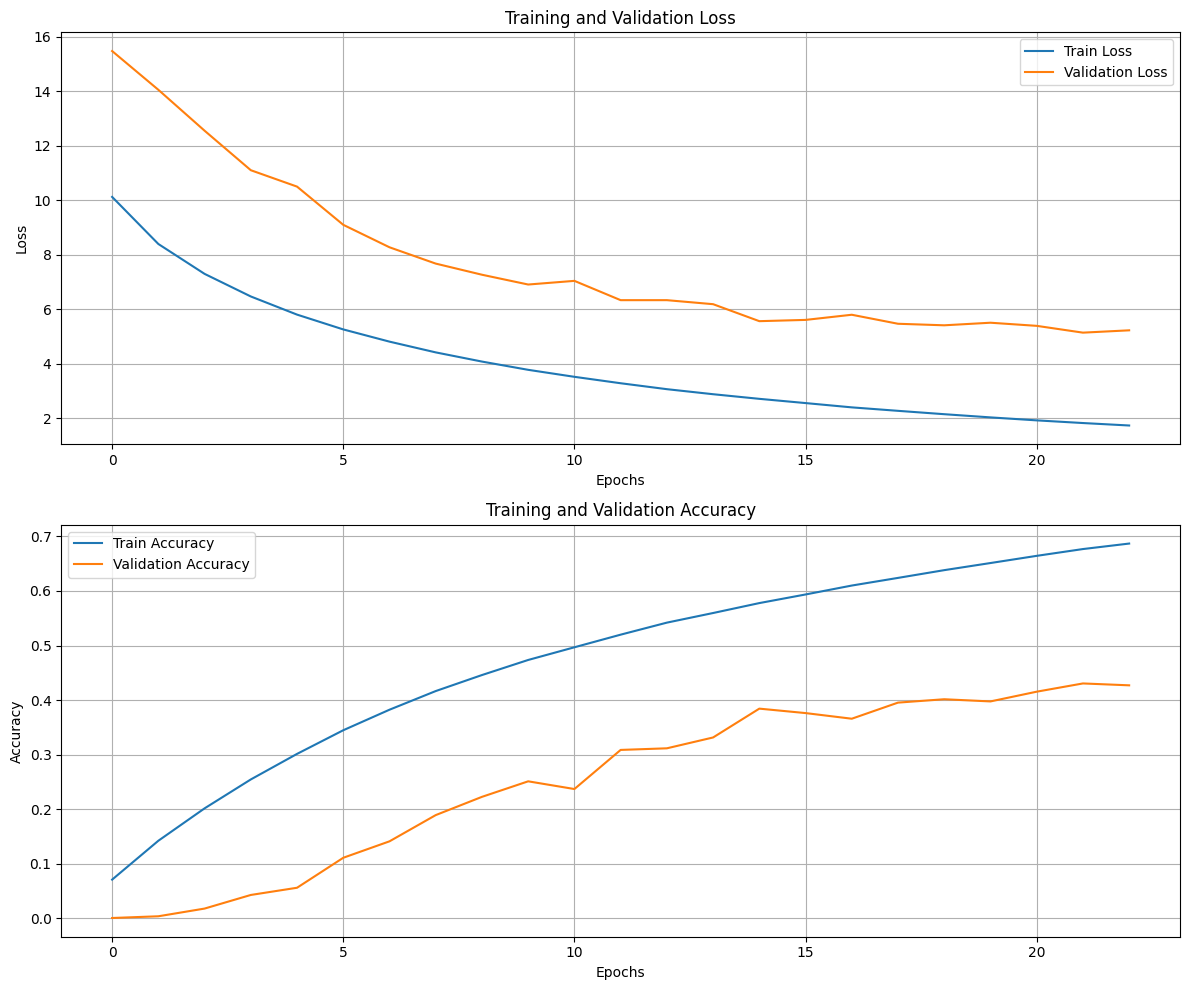

In [ ]:
# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['dev_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['dev_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
def face_age_prediction(model, image):
    # Use same transformer as training
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
    ])

    # If it's a NumPy array, convert to PIL Image first
    if isinstance(image, np.ndarray):
        from PIL import Image
        image = Image.fromarray(image)

    image = transformer(image)  # Now it's a float tensor in [0,1], shape (C, H, W)
    image = image.unsqueeze(0)  # Add batch dimension

    image = image.to(next(model.parameters()).device)

    model.eval()
    with torch.no_grad():
        embedding = model(image)  # model without label → normalized embeddings
    return embedding.squeeze().cpu()

In [ ]:
same_person_test = train_df[train_df['label'] == 'n000020'].sample(2)

In [ ]:
image1 = cv2.imread(same_person_test.iloc[0,0])
image2 = cv2.imread(same_person_test.iloc[1,0])
img_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

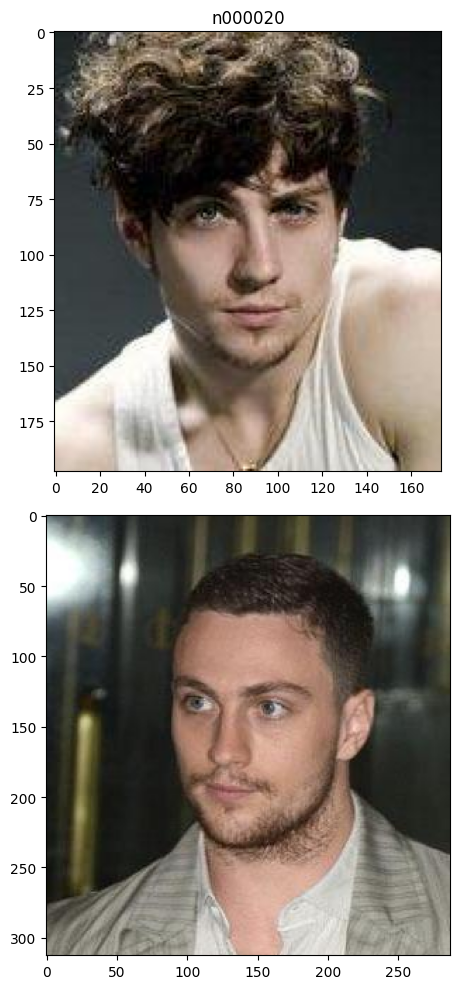

In [ ]:
# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.imshow(img_rgb1)
plt.title(f"{same_person_test.iloc[0,1]}")
plt.subplot(2, 1, 2)
plt.imshow(img_rgb2)
plt.tight_layout()
plt.show()

In [ ]:
img1 = face_age_prediction(model, img_rgb1)
img2 = face_age_prediction(model, img_rgb2)
emb1 = img1.view(img1.size(0), -1)
emb2 = img2.view(img2.size(0), -1)

In [ ]:
cos_sim = F.cosine_similarity(emb1, emb2)
print(cos_sim.shape)  # torch.Size([128])

# Get average similarity
avg_sim = cos_sim.mean().item()
print("Average similarity:", avg_sim)

torch.Size([512])
Average similarity: 0.40234375
